# Fundamentals Based - Outline

This notebook contains four different machine learning algorithms trained to predict win probabilities of basketball matchups:

* Logistic Regression
* Naive Bayes
* Random Forest Classifier
* Neural Network





In [1]:
#Importing important Libraries
%tensorflow_version 2.x
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split #for train_test_split
import tensorflow as tf #import tensorflow
from tensorflow.keras import layers, optimizers #import tensorflow
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
print(tf.__version__)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


2.2.0-rc3


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Feature Selection
As this is based on fundamentals, the features selected pertain to what are deemed "Team Stats". This ignores individual performance as all the stats are aggregated by team and by season. 

The features are: 
* Free Throw Attempts
* 3 Point Shot Attempts
* Defensive Rebounds
* Assists
* Turnovers
* Steals
* Blocks
* Personal Fouls
* Free Throw Shooting Percentage (Made FTs / Attempted FTs)
* Offensive Efficiency (Points / Offensive Possesion)
* Defensive Efficiency (Points Allowed / Defensive Possessions)
* Net Efficiency (Offensive Efficiency - Defensive Efficiency)



For each game that we have data on, we get two rows of data: 1 row represents the perspective of the winning team and 1 row represents the perspective of the losing team. As we are looking at differences between the winning and losing team, a negative value for Free Throw Attempts would signal that Team A shot less free throws than Team B

In [3]:
season_compact = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
season_compact = season_compact[season_compact['Season'] > 2002]
season = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv")
tourney_results = pd.read_csv("/content/gdrive//My Drive/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv")

#get aggregated stats for games teams won
season_details_winners = season[[ 'WTeamID','Season', 'WScore', 'LScore',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

season_details_winners.columns = [ 'WTeamID','Season', 'Points', 'PointsAllowed',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']

season_details_winners = season_details_winners.rename(columns={"WTeamID":"TeamID"}).groupby(['TeamID', 'Season']).sum()
season_details_winners['2PShooting'] = season_details_winners['WFGM'] / season_details_winners['WFGA']
season_details_winners['3PShooting'] = season_details_winners['WFGM3'] / season_details_winners['WFGA3']
season_details_winners['FTPercentage'] = season_details_winners['WFTM'] / season_details_winners['WFTA']

season_details_winners['O-2PShooting'] = season_details_winners['LFGM'] / season_details_winners['LFGA']
season_details_winners['O-3PShooting'] = season_details_winners['LFGM3'] / season_details_winners['LFGA3']
season_details_winners['O-FTPercentage'] = season_details_winners['LFTM'] / season_details_winners['LFTA']
season_details_winners.reset_index(inplace=True)

#get aggregated stats for games teams lost
season_details_losers = season[[ 'LTeamID','Season', 'LScore', 'WScore',
       'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF']]

season_details_losers.columns = ['LTeamID','Season', 'Points', 'PointsAllowed',
       'LFGM', 'LFGA', 'LFGM3', 'LFGA3','LFTM', 'LFTA', 'LOR', 'LDR', 
       'LAst', 'LTO', 'LStl', 'LBlk', 'LPF', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 
       'WFTM', 'WFTA', 'WOR', 'WDR','WAst', 'WTO', 'WStl', 'WBlk', 'WPF']

#calculate percentages
season_details_losers = season_details_losers.rename(columns={"LTeamID":"TeamID"}).groupby(['TeamID', 'Season']).sum()
season_details_losers['2PShooting'] = season_details_losers['LFGM'] / season_details_losers['LFGA']
season_details_losers['3PShooting'] = season_details_losers['LFGM3'] / season_details_losers['LFGA3']
season_details_losers['FTPercentage'] = season_details_losers['LFTM'] / season_details_losers['LFTA']

season_details_losers['O-2PShooting'] = season_details_losers['WFGM'] / season_details_losers['WFGA']
season_details_losers['O-3PShooting'] = season_details_losers['WFGM3'] / season_details_losers['WFGA3']
season_details_losers['O-FTPercentage'] = season_details_losers['WFTM'] / season_details_losers['WFTA']
season_details_losers.reset_index(inplace=True)

season_details = pd.concat((season_details_winners, season_details_losers))


season_details = season_details.groupby(['TeamID', 'Season']).sum().reset_index()

season_details.columns = ['TeamID', 'Season', 'Points','PointsAllowed','FGM', 'FGA', 
                          'FGM3', 'FGA3', 'FTM', 'FTA',
       'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 'OFGM', 'OFGA',
       'OFGM3', 'OFGA3', 'OFTM', 'OFTA', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl',
       'OBlk', 'OPF', '2PShooting', '3PShooting', 'FTPercentage',
       'O-2PShooting', 'O-3PShooting', 'O-FTPercentage']

season_details['2PShooting'] = season_details['2PShooting'] / 2
season_details['3PShooting'] = season_details['2PShooting'] / 2
season_details['FTPercentage'] = season_details['FTPercentage'] / 2

season_details['O-2PShooting'] = season_details['O-2PShooting'] / 2
season_details['O-3PShooting'] = season_details['O-3PShooting'] / 2
season_details['O-FTPercentage'] = season_details['O-FTPercentage'] / 2

season_details['Off-Efficiency'] = 100 * (season_details['Points'] / (season_details['FGA'] - season_details['OR'] 
          + season_details['TO'] + (0.475 * season_details['FTA'])))

season_details['Def-Efficiency'] = 100 * (season_details['PointsAllowed'] / (season_details['OFGA'] - season_details['OOR'] 
          + season_details['OTO'] + (0.475 * season_details['OFTA'])))
season_details = season_details[['TeamID', 'Season', 'FTA', 'OFTA', 'FGA', 'FGA3', 'OFGA', 'OFGA3', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF',
       'OOR', 'ODR', 'OAst','OTO', 'OStl', 'OBlk', 'OPF', '2PShooting', '3PShooting', 'FTPercentage', 'Off-Efficiency', 'Def-Efficiency']]

season_details['FTA'] = season_details['FTA'] - season_details['OFTA']
season_details['FGA'] = season_details['FGA'] - season_details['OFGA']
season_details['FGA3'] = season_details['FGA3'] - season_details['OFGA3']
season_details['OR'] = season_details['OR'] - season_details['OOR']
season_details['DR'] = season_details['DR'] - season_details['ODR']
season_details['Ast'] = season_details['Ast'] - season_details['OAst']
season_details['TO'] = season_details['TO'] - season_details['OTO']
season_details['Stl'] = season_details['Stl'] - season_details['OStl']
season_details['Blk'] = season_details['Blk'] - season_details['OBlk']
season_details['PF'] = season_details['PF'] - season_details['OPF']

#season_details = season_details.drop(columns=['OFGA', 'OFGA3', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF'])
season_details = season_details.drop(columns=['2PShooting', '3PShooting', 'FGA', 'OR', 'OFGA', 'OFGA3', 'OOR', 'ODR', 'OAst', 'OTO', 'OStl', 'OBlk', 'OPF'])

season_details

season_details

,TeamID,Season,FTA,OFTA,FGA3,DR,Ast,TO,Stl,Blk,PF,FTPercentage,Off-Efficiency,Def-Efficiency
0,1101,2014,-97,542,35,-79,-117,60,-26,-74,61,0.736352,93.950934,116.559003
1,1101,2015,-217,636,69,-175,-30,-18,2,-86,114,0.728859,94.415500,110.422041
2,1101,2016,-87,674,100,-73,1,-1,44,-23,73,0.745301,100.542428,108.359866
3,1101,2017,-131,595,-13,-54,0,-8,24,-10,123,0.700993,98.297034,105.054595
4,1101,2018,-129,633,6,-49,50,-29,17,19,91,0.708317,99.926679,102.573467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5829,1464,2017,-66,611,-27,-113,-54,-10,-9,-15,-2,0.695199,100.792623,110.583763
5830,1464,2018,-141,689,56,-133,-103,-1,12,-28,108,0.737858,99.124439,113.922476
5831,1464,2019,-234,676,179,-53,-15,49,6,2,168,0.727887,103.816003,111.800950
5832,1465,2019,-132,625,178,34,-16,44,-31,0,77,0.771093,107.085841,106.663029


#Now we need to create our training set
In order to do this, we need to recognize the two different perspectives we get from each game. We create two dataframes, create a winner's perspective and a loser's perspective. Then we add our target column, 'Result', which will have a value of 1 for the winner's and a value of 0 for the loser's. We then combine the two tables back together to form our training set. 

In [4]:
# aggregate wins and losses with stats for each team
season_details['Season'] = season_details['Season'].astype(str)
season_details['TeamID'] = season_details['TeamID'].astype(str)

season_compact['Season'] = season_compact['Season'].astype(str)
season_compact['WTeamID'] = season_compact['WTeamID'].astype(str)
season_compact['LTeamID'] = season_compact['LTeamID'].astype(str)

season_compact = season_compact.merge(season_details, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])
season_compact = season_compact.merge(season_details, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns=['TeamID'])

season_details_wins = pd.DataFrame()
season_details_wins['Season'] = season_compact['Season']
season_details_wins['DayNum'] = season_compact['DayNum']
season_details_wins['WTeamID'] = season_compact['WTeamID']
season_details_wins['LTeamID'] = season_compact['LTeamID']

season_details_wins['FTA'] = season_compact['FTA_x'] - season_compact['FTA_y']
season_details_wins['FGA3'] = season_compact['FGA3_x'] - season_compact['FGA3_y']
season_details_wins['DR'] = season_compact['DR_x'] - season_compact['DR_y']
season_details_wins['Ast'] = season_compact['Ast_x'] - season_compact['Ast_y']
season_details_wins['TO'] = season_compact['TO_x'] - season_compact['TO_y']
season_details_wins['Stl'] = season_compact['Stl_x'] - season_compact['Stl_y']
season_details_wins['Blk'] = season_compact['Blk_x'] - season_compact['Blk_y']
season_details_wins['PF'] = season_compact['PF_x'] - season_compact['PF_y']
season_details_wins['FTPercentage'] = season_compact['FTPercentage_x'] - season_compact['FTPercentage_y']
season_details_wins['Net-Efficiency'] = season_compact['Off-Efficiency_x'] - season_compact['Def-Efficiency_y']
season_details_wins['Off-Efficiency'] = season_compact['Off-Efficiency_x']
season_details_wins['Def-Efficiency'] = season_compact['Def-Efficiency_x']
season_details_wins['Result'] = 1

season_details_loss = pd.DataFrame()
season_details_loss['Season'] = season_compact['Season']
season_details_loss['DayNum'] = season_compact['DayNum']
season_details_loss['WTeamID'] = season_compact['WTeamID']
season_details_loss['LTeamID'] = season_compact['LTeamID']

season_details_loss['FTA'] = season_compact['FTA_y'] - season_compact['FTA_x']
season_details_loss['FGA3'] = season_compact['FGA3_y'] - season_compact['FGA3_x']
season_details_loss['DR'] = season_compact['DR_y'] - season_compact['DR_x']
season_details_loss['Ast'] = season_compact['Ast_y'] - season_compact['Ast_x']
season_details_loss['TO'] = season_compact['TO_y'] - season_compact['TO_x']
season_details_loss['Stl'] = season_compact['Stl_y'] - season_compact['Stl_x']
season_details_loss['Blk'] = season_compact['Blk_y'] - season_compact['Blk_x']
season_details_loss['PF'] = season_compact['PF_y'] - season_compact['PF_x']
season_details_loss['FTPercentage'] = season_compact['FTPercentage_y'] - season_compact['FTPercentage_x']
season_details_loss['Net-Efficiency'] = season_compact['Off-Efficiency_y'] - season_compact['Def-Efficiency_x']
season_details_loss['Off-Efficiency'] = season_compact['Off-Efficiency_y']
season_details_loss['Def-Efficiency'] = season_compact['Def-Efficiency_y']
season_details_loss['Result'] = 0

season_pred = pd.concat((season_details_wins, season_details_loss))

season_pred


,Season,DayNum,WTeamID,LTeamID,FTA,FGA3,DR,Ast,TO,Stl,Blk,PF,FTPercentage,Net-Efficiency,Off-Efficiency,Def-Efficiency,Result
0,2003,10,1104,1328,107,-142,-41,-99,41,-23,-16,-66,0.016745,11.835504,103.668475,97.587131,1
1,2003,10,1272,1393,-74,246,-65,123,-13,-46,-65,57,0.017379,8.808177,105.548501,93.465036,1
2,2003,11,1266,1437,159,-139,130,119,58,-18,42,-56,0.021081,16.787395,115.406354,100.126810,1
3,2003,11,1296,1457,-16,-181,75,-23,107,-68,-49,-8,0.048892,6.435594,102.828008,103.445391,1
4,2003,11,1400,1208,8,41,93,-1,30,-59,-13,43,-0.030677,7.409711,111.102725,97.476904,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87499,2019,132,1153,1222,-250,231,95,75,73,-40,47,152,0.069886,16.212491,111.864075,90.884288,0
87500,2019,132,1209,1426,-117,126,91,96,153,-91,-81,32,0.035151,-4.053232,98.355879,100.039130,0
87501,2019,132,1277,1276,-46,270,-279,-92,-195,123,-57,18,-0.037223,13.270000,108.141085,89.436920,0
87502,2019,132,1387,1382,-216,-100,-19,4,-16,-38,62,60,0.085351,4.552280,99.777164,95.468049,0


In [5]:
# scale inputs

scaler = preprocessing.MinMaxScaler(feature_range=(-10,10))

season_pred['FTA'] = scaler.fit_transform(season_pred['FTA'].values.reshape(-1,1))
season_pred['FGA3'] = scaler.fit_transform(season_pred['FGA3'].values.reshape(-1,1))
season_pred['DR'] = scaler.fit_transform(season_pred['DR'].values.reshape(-1,1))
season_pred['Ast'] = scaler.fit_transform(season_pred['Ast'].values.reshape(-1,1))
season_pred['TO'] = scaler.fit_transform(season_pred['TO'].values.reshape(-1,1))
season_pred['Stl'] = scaler.fit_transform(season_pred['Stl'].values.reshape(-1,1))
season_pred['Blk'] = scaler.fit_transform(season_pred['Blk'].values.reshape(-1,1))
season_pred['PF'] = scaler.fit_transform(season_pred['PF'].values.reshape(-1,1))
season_pred['FTPercentage'] = scaler.fit_transform(season_pred['FTPercentage'].values.reshape(-1,1))


season_pred['Net-Efficiency'] = scaler.fit_transform(season_pred['Net-Efficiency'].values.reshape(-1,1))
season_pred['Off-Efficiency'] = scaler.fit_transform(season_pred['Off-Efficiency'].values.reshape(-1,1))
season_pred['Def-Efficiency'] = scaler.fit_transform(season_pred['Def-Efficiency'].values.reshape(-1,1))

copy = season_pred.copy()

season_pred = season_pred.drop(columns=['Season', 'DayNum', 'WTeamID', 'LTeamID'])
season_preds = season_pred.sample(frac=1)
season_pred = season_preds[0:140000]
season_test = season_preds[140000:]
season_pred

,FTA,FGA3,DR,Ast,TO,Stl,Blk,PF,FTPercentage,Net-Efficiency,Off-Efficiency,Def-Efficiency,Result
8172,-1.574803,-0.729761,0.668740,1.677019,0.389610,-1.128527,0.189394,0.739857,-1.124518,2.506095,2.369922,-2.193857,0
35555,2.585302,2.531357,0.575428,3.457557,-2.922078,1.285266,2.765152,-4.343675,-0.434156,1.439379,5.070382,-5.239921,1
61447,2.808399,-0.855188,-0.917574,-2.960663,-0.649351,-1.661442,0.151515,-2.887828,0.309749,1.992469,2.059916,0.927471,1
6405,1.102362,-0.057013,0.202177,2.380952,-2.705628,1.818182,1.893939,-1.073986,1.496402,3.518596,3.686031,-4.356744,1
62770,-2.047244,0.285063,-2.426128,-1.014493,-2.207792,-0.156740,-4.659091,2.625298,-0.877363,0.910766,0.967141,2.028852,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21089,-1.325459,0.866591,-2.192846,-1.118012,-3.831169,4.106583,-1.628788,2.673031,0.379662,1.876777,1.663677,-0.040259,1
14023,0.354331,-1.311288,-1.228616,-1.842650,0.670996,-3.385580,-2.727273,-0.143198,0.029178,2.436426,-1.148533,-0.109420,0
8006,0.564304,0.125428,-3.219285,-2.008282,-2.532468,2.915361,-2.878788,-0.596659,0.272514,1.497852,-1.144375,-2.002652,1
64644,-0.262467,-2.599772,3.888025,1.407867,1.190476,-0.438871,1.212121,0.405728,-0.050677,2.058883,4.828551,-2.621742,0


#Determine the important features
Running a Random Forest Regressor, we can get an idea of the weights of our features before loading them into our ML algorithms.

The output tells us that Assists, Defensive Rebounds, and Turnovers are the three most important weights. These are known as hustle stats, a reflection of a teams ability to work together. 

In [6]:
#find important features

features = season_pred[['FTA','FGA3','DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 
       'FTPercentage', 'Net-Efficiency', 'Off-Efficiency', 'Def-Efficiency']]

label = season_pred[['Result']]

#test_features = season_test[['FTA', 'FGA', 'FGA3','OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', '2PShooting', '3PShooting',
#       'FTPercentage', 'Net-Efficiency', 'Off-Efficiency', 'Def-Efficiency']]
test_features = season_test[['FTA','FGA3','DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 
       'FTPercentage', 'Net-Efficiency', 'Off-Efficiency', 'Def-Efficiency']]



test_label = season_test[['Result']]

rf = RandomForestRegressor()
rf.fit(features, label)
rf.score(test_features, test_label)

fi = pd.DataFrame(rf.feature_importances_, index = features.columns, columns=['importance']).sort_values('importance', ascending=False)

fi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


,importance
Ast,0.203949
DR,0.120883
TO,0.114693
FTA,0.081477
FGA3,0.068028
Stl,0.062951
FTPercentage,0.062306
Blk,0.060900
Def-Efficiency,0.059438
Off-Efficiency,0.055484


#Logistic Regression Model
The first attempt was to use a logistic regression model. This would set a baseline for the dataset as it is one of the more basic machine learning models. 

In [0]:
#This creates our train and test sets for our logistic regression, naive bayes, and random forest models. 
all_data = copy.sample(frac=1)
train = all_data[0:140000]
test = all_data[140000:]

parameters = train[['FTA','FGA3','DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 
       'FTPercentage', 'Net-Efficiency', 'Off-Efficiency', 'Def-Efficiency']].values
labels = train[['Result']].values

test_parameters = test[['FTA','FGA3','DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF', 
       'FTPercentage', 'Net-Efficiency', 'Off-Efficiency', 'Def-Efficiency']].values
test_labels = test[['Result']].values

In [8]:
#Logistic Regression Model
log_reg = LogisticRegression(random_state=0).fit(parameters, labels)

target_pred = log_reg.predict(test_parameters)
target_proba = log_reg.predict_proba(test_parameters)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.7293475776965265
LogLoss:  0.5341200473193233


In [9]:
lm_probs = pd.DataFrame(target_proba)
lm_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.500875,0.499125
std,0.267010,0.267010
min,0.001720,0.001035
25%,0.273943,0.272033
50%,0.502023,0.497977
75%,0.727967,0.726057
max,0.998965,0.998280


##Naive Bayes
The first attempt was to use a Naive Bayes. After running the Naive Bayes on many features, it was found that as more features were added, the worse the NB algorithm performed. So the final Naive Bayes algorithm takes the 4 most important features as determined by the above Random Forest Regressor. 

In [10]:
clf = GaussianNB()
clf.fit(parameters, labels)

target_pred = clf.predict(test_parameters)
target_proba = clf.predict_proba(test_parameters)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7134369287020109
LogLoss:  0.6981517291785344


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
#@title Naive Bayes Classifier
clf = GaussianNB()
params = train[['Ast', 'DR', 'TO' ]].values
test_pars = test[['Ast', 'DR', 'TO']].values
clf.fit(params, labels)

target_pred = clf.predict(test_pars)
target_proba = clf.predict_proba(test_pars)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)

print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

Accuracy:  0.7042390310786106
LogLoss:  0.5695632011821425


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
nb_probs = pd.DataFrame(target_proba)
nb_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.499963,0.500037
std,0.282734,0.282734
min,0.000826,0.000544
25%,0.252197,0.252108
50%,0.502059,0.497941
75%,0.747892,0.747803
max,0.999456,0.999174


The Naive Bayes classifier performed fairly well. The accuracy is relatively good but the logloss is a little high. 
Remember: LogLoss represents our confidence in our probabilities. 
Let's try a neural network. 

#Random Forest

In [13]:
rf = RandomForestClassifier(max_depth=10, random_state=0,  max_features=12)
rf.fit(parameters, labels)

target_pred = rf.predict(test_parameters)
target_proba = rf.predict_proba(test_parameters)
accuracy = accuracy_score(test_labels, target_pred, normalize = True)
logloss = log_loss(test_labels, target_proba)
print("Accuracy: ", accuracy)
print("LogLoss: ", logloss)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy:  0.7245201096892139
LogLoss:  0.5413458772450692


In [14]:
rf_probs = pd.DataFrame(target_proba)
rf_probs.describe()

,0,1
count,35008.000000,35008.000000
mean,0.500875,0.499125
std,0.259816,0.259816
min,0.013742,0.012543
25%,0.287506,0.284017
50%,0.502254,0.497746
75%,0.715983,0.712494
max,0.987457,0.986258


In [0]:
# Define methods for creating and training our neural net
import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

def plot_the_loss_curve(epochs, mse):
  """Plot a curve of loss vs. epoch."""

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("binary cross entropy")

  plt.plot(epochs, mse, label="Loss")
  plt.legend()
  plt.ylim([mse.min()*0.95, mse.max() * 1.03])
  plt.show()  



def create_model_stats(my_learning_rate, my_feature_layer):
  """Create and compile a simple linear regression model."""
  # Most simple tf.keras models are sequential.
  model = tf.keras.models.Sequential()

  # Add the layer containing the feature columns to the model.
  model.add(my_feature_layer)

  # Describe the topography of the model by calling the tf.keras.layers.Dense
  # method once for each layer. We've specified the following arguments:
  #   * units specifies the number of nodes in this layer.
  #   * activation specifies the activation function (Rectified Linear Unit).
  #   * name is just a string that can be useful when debugging.

  
  model.add(tf.keras.layers.Dense(units=12, 
                                  activation='relu', 
                                  name='Hidden1'))
  
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.GaussianDropout(0.15))
  # Define the second hidden layer with 12 nodes. 
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden2'))

  model.add(tf.keras.layers.Dense(units=256, 
                                  activation='relu', 
                                  name='Hidden3'))
    
  model.add(tf.keras.layers.GaussianDropout(0.15))
  model.add(tf.keras.layers.Dense(units=128, 
                                  activation='relu', 
                                  name='Hidden3'))

  model.add(tf.keras.layers.Dense(64, 
                                  kernel_regularizer=tf.keras.regularizers.L1L2(0.01, 0.01)))


    
  # Define the output layer.
  model.add(tf.keras.layers.Dense(units=1,  
                                  activation='relu',
                                  name='Output')) 
  
  model.compile(optimizer=tf.keras.optimizers.Adam(lr=my_learning_rate),
                loss="binary_crossentropy",
                metrics=['accuracy'])

  return model          


def train_model(model, dataset, epochs, label_name,batch_size=None):
  """Train the model by feeding it data."""

  # Split the dataset into features and label.
  features = {name:np.array(value) for name, value in dataset.items()}
  label = np.array(features.pop(label_name))
  history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=True, validation_split=0.2) 

  # The list of epochs is stored separately from the rest of history.
  epochs = history.epoch
  
  # To track the progression of training, gather a snapshot
  # of the model's mean squared error at each epoch. 
  hist = pd.DataFrame(history.history)
  mse = hist["loss"]

  return epochs, mse  

Our Neural Network can take in more features than our Naive Bayes classifier. We will keep all the features that we had and run our neural net. Each feature is loaded in as a numeric column. 

Epoch 1/700

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

56/56 [==============================] - 1s 12ms/step - loss: 9.6166 - accuracy: 0.5867 - val_loss: 8.6964 - val_accuracy: 0.6302
Epoch 2/700
56/56 [==============================] - 0s 6ms/step - loss: 8.8020 - accuracy: 0.6076 - val_loss: 8.4262 - val_accuracy: 0.6385
Epoch 3/700
56/56 [==============================] - 0s 6ms/step - loss: 8.5432 - accuracy: 0.6090 - val_loss: 8.2320 - val_accuracy: 0.6227
Epoch 4/700
56/56 [==============================] - 0s 6ms/step - loss: 8.3079 - ac

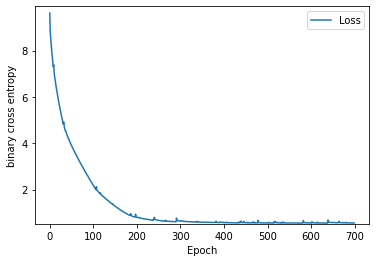


 Evaluate the neural network model against the test set:
18/18 [==============================] - 0s 4ms/step - loss: 0.5559 - accuracy: 0.7278
[0.5559020638465881, 0.7278050780296326]


In [16]:
#Run the neural net 
features = []
for col in season_pred.columns:
  features.append(col)
      
features.pop(-1)
features
feature_columns = feature_columns = [tf.feature_column.numeric_column(key = key) for key in features]

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

learning_rate = 0.0001
epochs = 700
batch_size = 2000
label_name = 'Result'

# Establish the model's topography.
my_model_stats = create_model_stats(learning_rate, my_feature_layer)

# Train the model on the normalized training set.
epochs, mse = train_model(my_model_stats, season_pred, epochs, label_name, batch_size)
plot_the_loss_curve(epochs, mse)

test_features = {name:np.array(value) for name, value in season_test.items()}
test_label = np.array(test_features.pop(label_name)) # isolate the label
print("\n Evaluate the neural network model against the test set:")
print(my_model_stats.evaluate(x = test_features, y = test_label, batch_size=batch_size))

Our Neural Network performed better here. The accuracy was a little higher and the logloss was lower on our test set. 

This will construct the probability distributions for our four models. 

Instructions for updating:
Please use `model.predict()` instead.


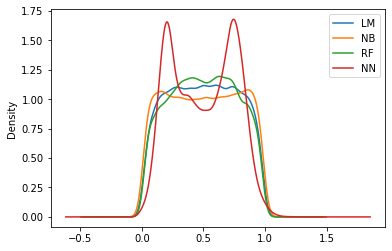

In [17]:
nn_probs = my_model_stats.predict_proba(x = test_features, batch_size=batch_size)
nn_probs = pd.DataFrame(nn_probs)
lm_probs = lm_probs.drop(1, axis=1).rename(columns={0 : 'LM'})
nb_probs = nb_probs.drop(1, axis=1).rename(columns={0 : 'NB'})
rf_probs = rf_probs.drop(1, axis=1).rename(columns={0 : 'RF'})
nn_probs = nn_probs.rename(columns={0 : 'NN'})


probs = pd.DataFrame()
probs['LM'] = lm_probs['LM']
probs['NB'] = nb_probs['NB']
probs['RF'] = rf_probs['RF']
probs['NN'] = nn_probs['NN']

probs.plot.kde()